# This notebook trains the semantic segmentation models using original images
Inspired by https://expoundai.wordpress.com/2019/08/30/transfer-learning-for-segmentation-using-deeplabv3-in-pytorch/

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/') # mount google drive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Dataset 
import torchvision.transforms as transforms

import torchvision.models as models

In [ ]:
device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

Cuda installed! Running on GPU!


# Function to create semantic segmentation models from pretrained models provided by Pytorch

In [ ]:
from torchvision.models.segmentation.deeplabv3 import DeepLabHead
from torchvision.models.segmentation.fcn import FCNHead

In [ ]:
### create segmentation models

def create_segmentation_model(network_type='DeepLabV3',backbone='Resnet101',outputchannels=5):
    """
    This function creates pretrained semantic segmentation models
    Attributes:
    network_type: options are 'DeepLabV3' and 'FCN'
    backbone: options are 'Resnet101' and 'Resnet50'
    outputchannels: number of classes in training set
    """

    if network_type == 'DeepLabV3':
        if backbone == 'Resnet101':
            print('Creating DeepLabV3-resnet101...')
            model = models.segmentation.deeplabv3_resnet101(pretrained=True, progress=True) 
        if backbone == 'Resnet50':
            print('Creating DeepLabV3-resnet50...')
            model = models.segmentation.deeplabv3_resnet50(pretrained=True, progress=True)           
        model.classifier = DeepLabHead(2048, outputchannels) # modify the classifier to suit new dataset
    if network_type == 'FCN':
        if backbone == 'Resnet101':
            print('Creating FCN-resnet101...')
            model = models.segmentation.fcn_resnet101(pretrained=True, progress=True)
        if backbone == 'Resnet50':
            print('Creating FCN-resnet50...')
            model = models.segmentation.fcn_resnet50(pretrained=True, progress=True)           
        model.classifier = model.classifier = FCNHead(2048, outputchannels) # modify the classifier to suit new dataset
    
    return model

### create directory for model saving

In [ ]:
import os

In [ ]:
model_base_dir = os.path.join('/content/gdrive/My Drive/acse9/models','segmentation_original_image')
if not os.path.exists(model_base_dir):
        os.mkdir(model_base_dir)
else:
    print('Directory exists!')

Directory exists!


# training and validation functions

# Load data for training

In [2]:
!ls "/content/gdrive/My Drive/acse9/data/Labelled_Image/Labelled_Image/" 

image  mask  p169_E12ESDKLNCL01_12.psd	p180_E6ESDRKLIN01_36.psd


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import glob

In [ ]:
# get the directory list of images and masks
ori_lst = glob.glob('/content/gdrive/My Drive/acse9/data/Labelled_Image/Labelled_Image/image/*')
mask_lst = glob.glob('/content/gdrive/My Drive/acse9/data/Labelled_Image/Labelled_Image/mask/*npy')
print(ori_lst, mask_lst)

['/content/gdrive/My Drive/acse9/data/Labelled_Image/Labelled_Image/image/p228_E15ESREGMAP01_56.psd', '/content/gdrive/My Drive/acse9/data/Labelled_Image/Labelled_Image/image/p220_E17ESREGMAP01_6.psd', '/content/gdrive/My Drive/acse9/data/Labelled_Image/Labelled_Image/image/p169_E12ESDKLNCL01_11.tif', '/content/gdrive/My Drive/acse9/data/Labelled_Image/Labelled_Image/image/p125_E12ESPWYCOL01_10.psd', '/content/gdrive/My Drive/acse9/data/Labelled_Image/Labelled_Image/image/p103_E19ESCOLOR_01_0.tif', '/content/gdrive/My Drive/acse9/data/Labelled_Image/Labelled_Image/image/p222_E11ESREGMAP01_44.psd'] ['/content/gdrive/My Drive/acse9/data/Labelled_Image/Labelled_Image/mask/p222_E11ESREGMAP01_44.npy', '/content/gdrive/My Drive/acse9/data/Labelled_Image/Labelled_Image/mask/p169_E12ESDKLNCL01_11.npy', '/content/gdrive/My Drive/acse9/data/Labelled_Image/Labelled_Image/mask/p125_E12ESPWYCOL01_10.npy', '/content/gdrive/My Drive/acse9/data/Labelled_Image/Labelled_Image/mask/p103_E19ESCOLOR_01_0.n

In [ ]:
# sort the list according to specific order
def get_4chars(x):
    return(x[73:76])
def get_4chars_mask(x):
    return(x[72:75])
ori_lst = sorted(ori_lst, key = get_4chars) 
mask_lst = sorted(mask_lst, key = get_4chars_mask) 


In [ ]:
print(ori_lst)
print(mask_lst)

['/content/gdrive/My Drive/acse9/data/Labelled_Image/Labelled_Image/image/p103_E19ESCOLOR_01_0.tif', '/content/gdrive/My Drive/acse9/data/Labelled_Image/Labelled_Image/image/p125_E12ESPWYCOL01_10.psd', '/content/gdrive/My Drive/acse9/data/Labelled_Image/Labelled_Image/image/p169_E12ESDKLNCL01_11.tif', '/content/gdrive/My Drive/acse9/data/Labelled_Image/Labelled_Image/image/p220_E17ESREGMAP01_6.psd', '/content/gdrive/My Drive/acse9/data/Labelled_Image/Labelled_Image/image/p222_E11ESREGMAP01_44.psd', '/content/gdrive/My Drive/acse9/data/Labelled_Image/Labelled_Image/image/p228_E15ESREGMAP01_56.psd']
['/content/gdrive/My Drive/acse9/data/Labelled_Image/Labelled_Image/mask/p103_E19ESCOLOR_01_0.npy', '/content/gdrive/My Drive/acse9/data/Labelled_Image/Labelled_Image/mask/p125_E12ESPWYCOL01_10.npy', '/content/gdrive/My Drive/acse9/data/Labelled_Image/Labelled_Image/mask/p169_E12ESDKLNCL01_11.npy', '/content/gdrive/My Drive/acse9/data/Labelled_Image/Labelled_Image/mask/p220_E17ESREGMAP01_6.np

In [ ]:
# load images 
def load_images(dir_list):
  """
  Load the data under the data directory
  """
  all_images = []

  for i in dir_list:
    img_path = i
    img = Image.open(img_path).convert('L') # open the image as grayscale

    img = np.array(img)
    all_images.append(img)
  
  return all_images


In [ ]:
all_images = load_images(ori_lst)

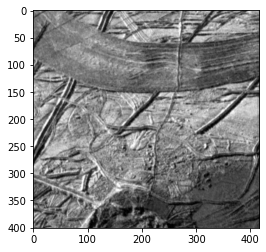

In [ ]:
plt.imshow(all_images[0],cmap='gray')

In [ ]:
# load masks
def load_masks(dir_list):
  """
  Load the masks under the dir_list 
  """
  all_masks = []

  for i in dir_list:
    data = np.load(i)
    all_masks.append(data)
  
  return all_masks

In [ ]:
all_masks = load_masks(mask_lst)

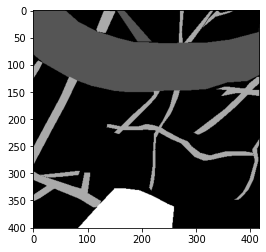

In [ ]:
plt.imshow(all_masks[0],cmap='gray')  

# Make Customized dataset

In [ ]:
# print the shape of all masks
for i in range(len(all_masks)):
    print(all_masks[i].shape)

(401, 417)
(536, 797)
(666, 675)
(5700, 3485)
(800, 800)
(800, 800)


In [ ]:
# print the shape of all images
for i in range(len(all_images)):
    print(all_images[i].shape)

(401, 417)
(536, 797)
(666, 675)
(5700, 3485)
(800, 800)
(800, 800)


# Optimize images

In [ ]:
import cv2

In [ ]:
 def auto_optim(original_image):
    """
    This function optimizes the contrast and brightness of the image
    """
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    optimised_image = clahe.apply(original_image)
    return optimised_image

# Crop images and masks

In [ ]:
def label_if_defect(img):
  """
  This function classifies those images into 4 classes:
  perfect images(0), with black defect(1), with white defect(2), black & white defect(3)
  """
  nb_black = len((np.where(img==0))[0]) # count number of black pixels in this image
  nb_white = len((np.where(img==255))[0]) # count number of white pixels in this image
  nb_pixels = img.shape[0]*img.shape[1]  # count number of pixels in this image

  label = 0
  if nb_black/nb_pixels > 0.1:
    label = 1
  if nb_white/nb_pixels > 0.1:
    if label == 1:
      label = 3
    if label == 0:
      label = 2

  return label

In [ ]:
def regular_crop(size,image,mask):
        """
        Original code is from Ke Wen, and I made a few revision to fit the segmentation task
        Crop images regularly into subimages with the size 
        Attribute:
            size: int, sub image dimension: size x size
        """
        h = image.shape[0]
        w = image.shape[1]

        if 0<size<h or 0<size<w: # check input size
            col = int(w/size)
            row = int(h/size)
            # print("number of images generated:", col*row)
            
            # crop from centre, ignore edges:
            start_left = int((w - col*size)/2)
            start_top = int((h - row*size)/2)
            # print("top left axis:", f'[{start_top},{start_left}]')
            cropped_image_set = []
            cropped_mask_set = []
            
            #start to crop:
            left = start_left
            top = start_top
            for j in range(row):
                for i in range(col):
                    cropped_image = image[top:top+size, left:left+size]
                    cropped_mask = mask[top:top+size, left:left+size]  # crop the mask
                    if label_if_defect(cropped_image) ==0: #passed defect check
                        cropped_image = auto_optim(cropped_image)
                        cropped_image_set.append(cropped_image)
                        cropped_mask_set.append(cropped_mask)
                        
                    left += size
                left = start_left
                top += size
            return np.array(cropped_image_set), np.array(cropped_mask_set) 
        
        else:
            print('No need to crop!')
            return image,mask

In [ ]:
cropping_size = 200 # crop the image to size 200 x 200
all_images_after_crop={}
all_masks_after_crop={}
for i in range(len(all_images)):
    if i ==0:
        all_images_after_crop,all_masks_after_crop = regular_crop(cropping_size,all_images[i],all_masks[i])
    else:
        if not i==3:  # skip the fourth image and mask as they are incomplete
            temp_images_after_crop,temp_masks_after_crop = regular_crop(cropping_size,all_images[i],all_masks[i])
            all_images_after_crop = np.concatenate((all_images_after_crop,temp_images_after_crop))
            all_masks_after_crop = np.concatenate((all_masks_after_crop,temp_masks_after_crop))

In [ ]:
# optimize and stack the orginal image to 3 channel if the original image is gray scale
all_images_after_crop_for_training = []

for i in range(len(all_images_after_crop)):
    img2 = auto_optim(all_images_after_crop[i])
    # process the gray-image
    if len(np.array(img2).shape) == 2:
        img2 = np.stack((img2, img2, img2),)
    all_images_after_crop_for_training.append(img2)

In [ ]:
print(np.array(all_images_after_crop_for_training).shape)

(44, 3, 200, 200)


# Original images and Mask are our X and Y for dataloader

In [ ]:
# !!!normalize our data
all_images_after_crop_for_training = np.array(all_images_after_crop_for_training)/255

In [ ]:
class CustomImageTensorDataset(Dataset):
    def __init__(self, data, targets, transform=None):
        """
        Args:
            data (Tensor): A tensor containing the data e.g. images
            targets (Tensor): A tensor containing all the labels
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data = data
        self.targets = targets
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample, label = self.data[idx], self.targets[idx]
        
        if self.transform:
            sample = self.transform(sample)

        return sample, label

In [ ]:
# identify hyperparameters
seed = 42
batch_size = 16
test_batch_size = 16
learning_rate = 1e-3
num_epochs = 50

split_rate = 0.1 # the percentage of validation set

s1 = np.random.choice(range(len(all_images_after_crop)), int(len(all_images_after_crop)*split_rate), replace=False)  # validation set indices
s2 = list(set(range(len(all_images_after_crop))) - set(s1))   # train set indices

print(len(s2)) # print the number of images in training set

# create train data loader
X_train = all_images_after_crop_for_training[s2]
y_train = all_masks_after_crop[s2]
train_set = CustomImageTensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=4) #create dataloader

# create validation set data loader
X_validate = all_images_after_crop_for_training[s1]
y_validate = all_masks_after_crop[s1]
validation_set = CustomImageTensorDataset(torch.from_numpy(X_validate).float(), torch.from_numpy(y_validate).long())
validation_loader = DataLoader(validation_set, batch_size=test_batch_size, shuffle=False, num_workers=4) #create dataloader

# create full dataloader
X_full = all_images_after_crop_for_training
y_full = all_masks_after_crop
full_set = CustomImageTensorDataset(torch.from_numpy(X_full).float(), torch.from_numpy(y_full).long())
full_loader = DataLoader(full_set, batch_size=batch_size, shuffle=False, num_workers=4) #create dataloader
print(len(X_full)) # print the number of images in full set
validation_images = all_images_after_crop[s1]
validation_masks = all_masks_after_crop[s1]

40
44


# Train the model

In [ ]:
!pip install pycm livelossplot
%pylab inline

     |████████████████████████████████| 61kB 1.9MB/s 
     |████████████████████████████████| 552kB 6.9MB/s 
Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['seed']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit

from livelossplot import PlotLosses
from pycm import *

In [ ]:
def train(model, optimizer, criterion, data_loader):
    """
    This function trains the model for one epoch
    """

    model.train()
    train_loss, train_accuracy = 0.0, 0.0
    for X, y in data_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = model(X.view(-1, 3, cropping_size, cropping_size))
        loss = criterion(outputs['out'], y)
        y_pred = F.log_softmax(outputs['out'], dim=1).max(1)[1]
        loss.backward()
        train_loss += loss*X.size(0)
        train_accuracy += accuracy_score(y.cpu().numpy().ravel(), y_pred.detach().cpu().numpy().ravel())*X.size(0)
        optimizer.step()         
    return train_loss/len(data_loader.dataset), train_accuracy/len(data_loader.dataset)

def validate(model, criterion, data_loader):
    """
    This function validate the model on validation set
    """
    model.eval()
    validation_loss, validation_accuracy = 0., 0.
    for X, y in data_loader:
        with torch.no_grad():
            X, y = X.to(device), y.to(device)
            outputs = model(X.view(-1, 3, cropping_size, cropping_size))
            loss = criterion(outputs['out'], y)
            validation_loss += loss*X.size(0)
            y_pred = F.log_softmax(outputs['out'], dim=1).max(1)[1]
            validation_accuracy += accuracy_score(y.cpu().numpy().ravel(), y_pred.detach().cpu().numpy().ravel())*X.size(0)

    return validation_loss/len(data_loader.dataset), validation_accuracy/len(data_loader.dataset)



In [ ]:
def fit(model,optimizer,criterion,train_data_loader,validation_data_loader,num_epochs,model_name):
    """
    This function trains the model and validate it for num_epochs 
    """
    liveloss = PlotLosses()
    min_epoch_num = 0
    min_val_loss = 1e10 # initialize minimum validation loss
    training_losses = []
    training_accuracies = []

    validation_losses = []
    validation_accuracies = []

    for epoch in range(num_epochs):
        logs = {}
        train_loss, train_accuracy = train(model, optimizer, criterion, train_data_loader)

        logs['' + 'log loss'] = train_loss.item()
        training_losses.append(train_loss.item())
        logs['' + 'accuracy'] = train_accuracy.item()
        training_accuracies.append(train_accuracy.item())

        validation_loss, validation_accuracy = validate(model, criterion, validation_data_loader)
        logs['val_' + 'log loss'] = validation_loss.item()
        validation_losses.append(validation_loss.item())
        logs['val_' + 'accuracy'] = validation_accuracy.item()
        validation_accuracies.append(validation_accuracy.item())


        if validation_loss < min_val_loss:
            dir = os.path.join(model_base_dir,'{}.pth'.format(model_name))
            torch.save(model.state_dict(), dir)
            min_val_loss = validation_loss
            min_epoch_num = epoch+1    # we need epoch number = min_epoch_num to achieve the minimum validation loss

        liveloss.update(logs)
        liveloss.draw()

    print('At epoch [{}/{}], get minimum validation loss: {:.4f}'.format(min_epoch_num,num_epochs,min_val_loss))
    return training_losses,training_accuracies,validation_losses,validation_accuracies

# Train DeepLabV3-Resnet101

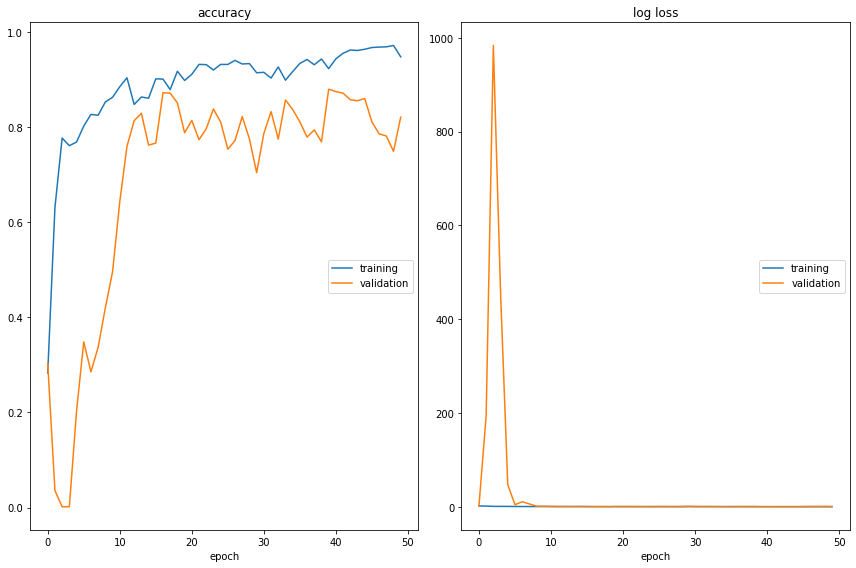

accuracy
	training         	 (min:    0.283, max:    0.971, cur:    0.947)
	validation       	 (min:    0.002, max:    0.879, cur:    0.820)
log loss
	training         	 (min:    0.080, max:    1.732, cur:    0.151)
	validation       	 (min:    0.380, max:  983.856, cur:    0.582)
At epoch [40/50], get minimum validation loss: 0.3797


In [ ]:
# model_deeplabv3
seed = 42
batch_size = 16
test_batch_size = 16
learning_rate = 1e-3
num_epochs = 50

model_deeplabv3 = create_segmentation_model().to(device)
liveloss = PlotLosses()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_deeplabv3.parameters(),lr=learning_rate,weight_decay=1e-3)

deeplabv3_resnet101_training_losses,deeplabv3_resnet101_training_accuracies,deeplabv3_resnet101_validation_losses,deeplabv3_resnet101_validation_accuracies = fit(model_deeplabv3,optimizer,criterion,train_loader,validation_loader,num_epochs,'deeplabv3_resnet101')

# Train Other Models  
https://pytorch.org/docs/stable/torchvision/models.html

In [ ]:
model_fcn_resnet50 = create_segmentation_model('FCN','Resnet50').to(device)

Creating FCN-resnet50...


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


Downloading: "https://download.pytorch.org/models/fcn_resnet50_coco-1167a1af.pth" to /root/.cache/torch/hub/checkpoints/fcn_resnet50_coco-1167a1af.pth


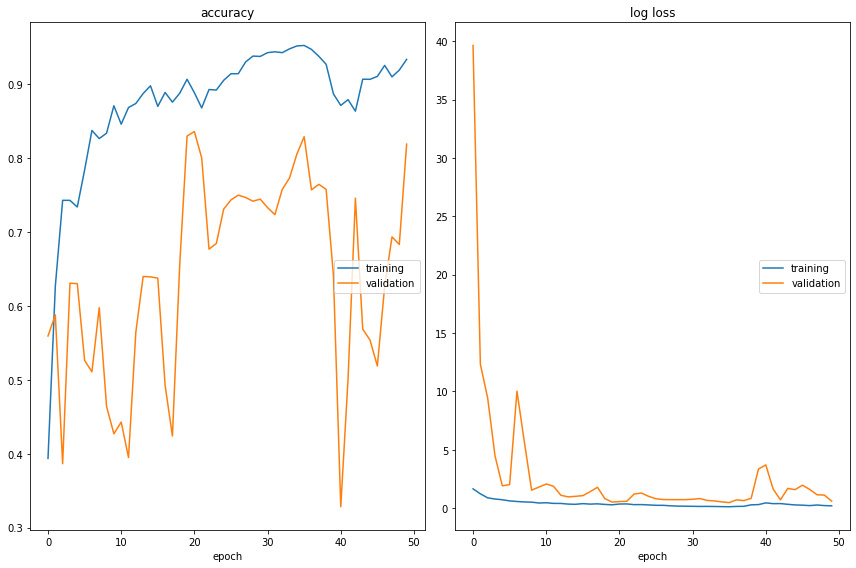

accuracy
	training         	 (min:    0.394, max:    0.952, cur:    0.933)
	validation       	 (min:    0.328, max:    0.836, cur:    0.819)
log loss
	training         	 (min:    0.116, max:    1.650, cur:    0.193)
	validation       	 (min:    0.472, max:   39.639, cur:    0.601)
At epoch [36/50], get minimum validation loss: 0.4720


In [ ]:
# train FCN-Resnet50
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_fcn_resnet50.parameters(),lr=learning_rate,weight_decay=1e-3)
fcn_resnet50_training_losses,fcn_resnet50_training_accuracies,fcn_resnet50_validation_losses,fcn_resnet50_validation_accuracies = fit(model_fcn_resnet50,optimizer,criterion,train_loader,validation_loader,num_epochs,'FCN_resnet50')

# FCN_Resnet101

In [ ]:
model_fcn_resnet101 = create_segmentation_model('FCN','Resnet101').to(device)

Creating FCN-resnet101...


Downloading: "https://download.pytorch.org/models/fcn_resnet101_coco-7ecb50ca.pth" to /root/.cache/torch/hub/checkpoints/fcn_resnet101_coco-7ecb50ca.pth


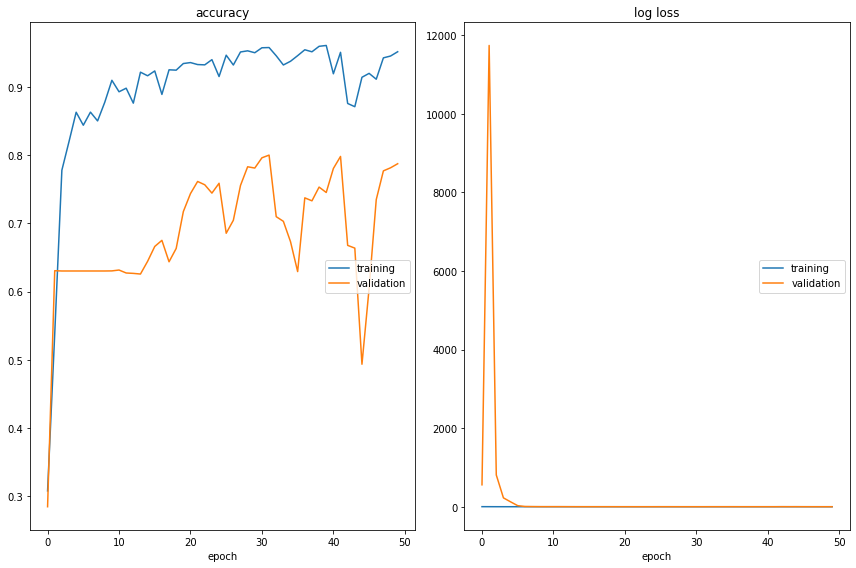

accuracy
	training         	 (min:    0.308, max:    0.961, cur:    0.952)
	validation       	 (min:    0.285, max:    0.800, cur:    0.788)
log loss
	training         	 (min:    0.098, max:    1.768, cur:    0.134)
	validation       	 (min:    0.543, max: 11743.223, cur:    0.601)
At epoch [32/50], get minimum validation loss: 0.5431


In [ ]:
# Train FCN-Resnet101
liveloss = PlotLosses()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_fcn_resnet101.parameters(),lr=learning_rate,weight_decay=1e-3)

fcn_resnet101_training_losses,fcn_resnet101_training_accuracies,fcn_resnet101_validation_losses,fcn_resnet101_validation_accuracies = fit(model_fcn_resnet101,optimizer,criterion,train_loader,validation_loader,num_epochs,'FCN_resnet101')

# DeepLabV3_resnet50

In [ ]:
model_deeplabv3_resnet50 = create_segmentation_model('DeepLabV3','Resnet50').to(device)

Creating DeepLabV3-resnet50...


Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth


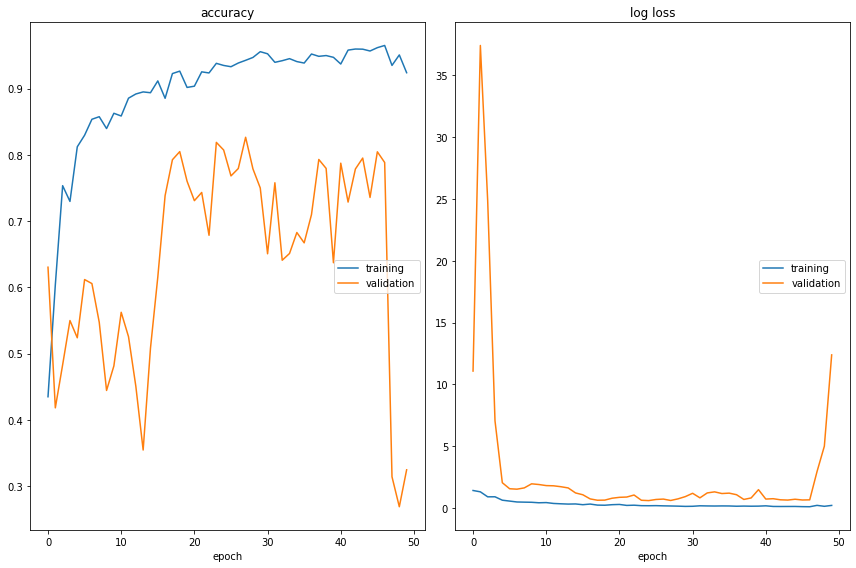

accuracy
	training         	 (min:    0.435, max:    0.965, cur:    0.924)
	validation       	 (min:    0.269, max:    0.826, cur:    0.325)
log loss
	training         	 (min:    0.095, max:    1.410, cur:    0.201)
	validation       	 (min:    0.591, max:   37.427, cur:   12.384)
At epoch [25/50], get minimum validation loss: 0.5915


In [ ]:
# Train Deeplabv3-resnet50
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_deeplabv3_resnet50.parameters(),lr=learning_rate,weight_decay=1e-3)
deeplabv3_resnet50_training_losses,deeplabv3_resnet50_training_accuracies,deeplabv3_resnet50_validation_losses,deeplabv3_resnet50_validation_accuracies = fit(model_deeplabv3_resnet50,optimizer,criterion,train_loader,validation_loader,num_epochs,'DeepLabV3_resnet50')

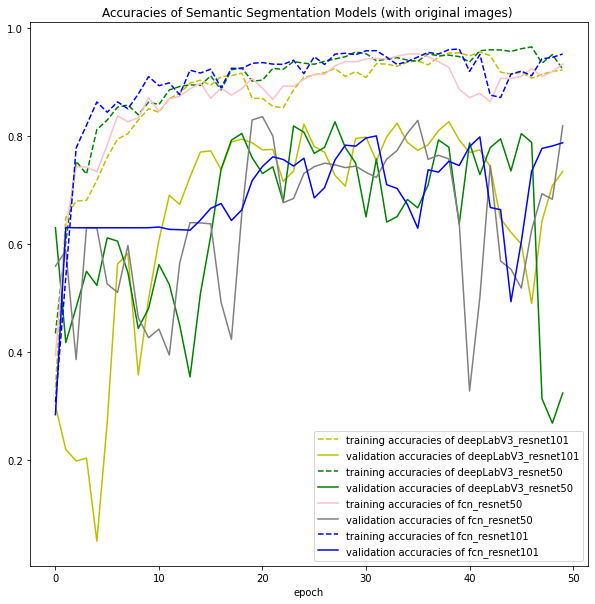

In [ ]:
# ensemble all accuracies of all models
plt.figure(figsize=(10,10))
plt.plot(range(0,50),deeplabv3_resnet101_training_accuracies,'y--',label = 'training accuracies of deepLabV3_resnet101')
plt.plot(range(0,50),deeplabv3_resnet101_validation_accuracies,'y-',label = 'validation accuracies of deepLabV3_resnet101')
plt.plot(range(0,50),deeplabv3_resnet50_training_accuracies,'g--',label = 'training accuracies of deepLabV3_resnet50')
plt.plot(range(0,50),deeplabv3_resnet50_validation_accuracies,'g-',label = 'validation accuracies of deepLabV3_resnet50')
plt.plot(range(0,50),fcn_resnet50_training_accuracies,'pink',label = 'training accuracies of fcn_resnet50')
plt.plot(range(0,50),fcn_resnet50_validation_accuracies,'gray',label = 'validation accuracies of fcn_resnet50')
plt.plot(range(0,50),fcn_resnet101_training_accuracies,'b--',label = 'training accuracies of fcn_resnet101')
plt.plot(range(0,50),fcn_resnet101_validation_accuracies,'b-',label = 'validation accuracies of fcn_resnet101')

plt.title('Accuracies of Semantic Segmentation Models (with original images) ')
plt.xlabel('epoch')
plt.legend()


# Choose DeepLabV3-Resnet101 for predictions

## Produce predictions

In [ ]:
def predict(model, criterion, data_loader):
    """
    This function predicts the pixel-wise labels 
    """
    model.eval()
    y_preds = []
    for X, y in data_loader:
        with torch.no_grad():
            X, y = X.to(device), y.to(device)
            outputs = model(X.view(-1, 3, cropping_size, cropping_size))
            loss = criterion(outputs['out'], y)
            y_pred = F.log_softmax(outputs['out'], dim=1).max(1)[1]
            y_preds.append(y_pred.detach().cpu().numpy())
    return np.concatenate(y_preds,0)

In [ ]:
model_deeplabv3_prediction = create_segmentation_model().to(device)
path = os.path.join(model_base_dir,'{}.pth'.format('deeplabv3_resnet101'))
model_deeplabv3_prediction.load_state_dict(torch.load(path)) # load the model that have been trained for prediction
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_deeplabv3_prediction.parameters(),lr=learning_rate,weight_decay=1e-3)

Creating DeepLabV3-resnet101...


In [ ]:
y_preds_full = predict(model_deeplabv3_prediction,criterion,full_loader)  # get the predictions of all images

# Visulization of Predictions all images

In [ ]:
def create_mask_image(mask_npy, show_im=False):
    """
    code from Ke Wen:
    Create mask image which can be save in .tif image format. 
    Convert the single channel mask with label (0, 1, 2, 3, 4) into 
    images with three channels with one color corresponding to one 
    class. 

    Args:
        mask_npy (numpy.array): Single channel mask label. Each pixel have a class number [0, 1, 2, 3, 4] corresponding to different classes
        show_im (bool, optional): Plot the mask. Defaults to False.

    Returns:
        numpy.array: mask with color in single image format [height, width, 3]
    """    
    height, width = mask_npy.shape[0], mask_npy.shape[1]
    img = np.zeros((height, width, 3), dtype=np.uint8) #3 channels to make image
    
    # differnt color for differnt classes
    color = [[255, 255, 255], # white: plain
            [0, 0, 128], # Navy Blue: band
            [0, 255, 0], # Green: Ridge
            [255, 255, 0], # Yellow: Chaos
            [255, 165, 0]] # Orange: Craters
    for i in range(5):
        xx, yy = np.where(mask_npy==i)
        img[xx, yy] = color[i]
        
    if show_im:
        plt.imshow(img)
    return img

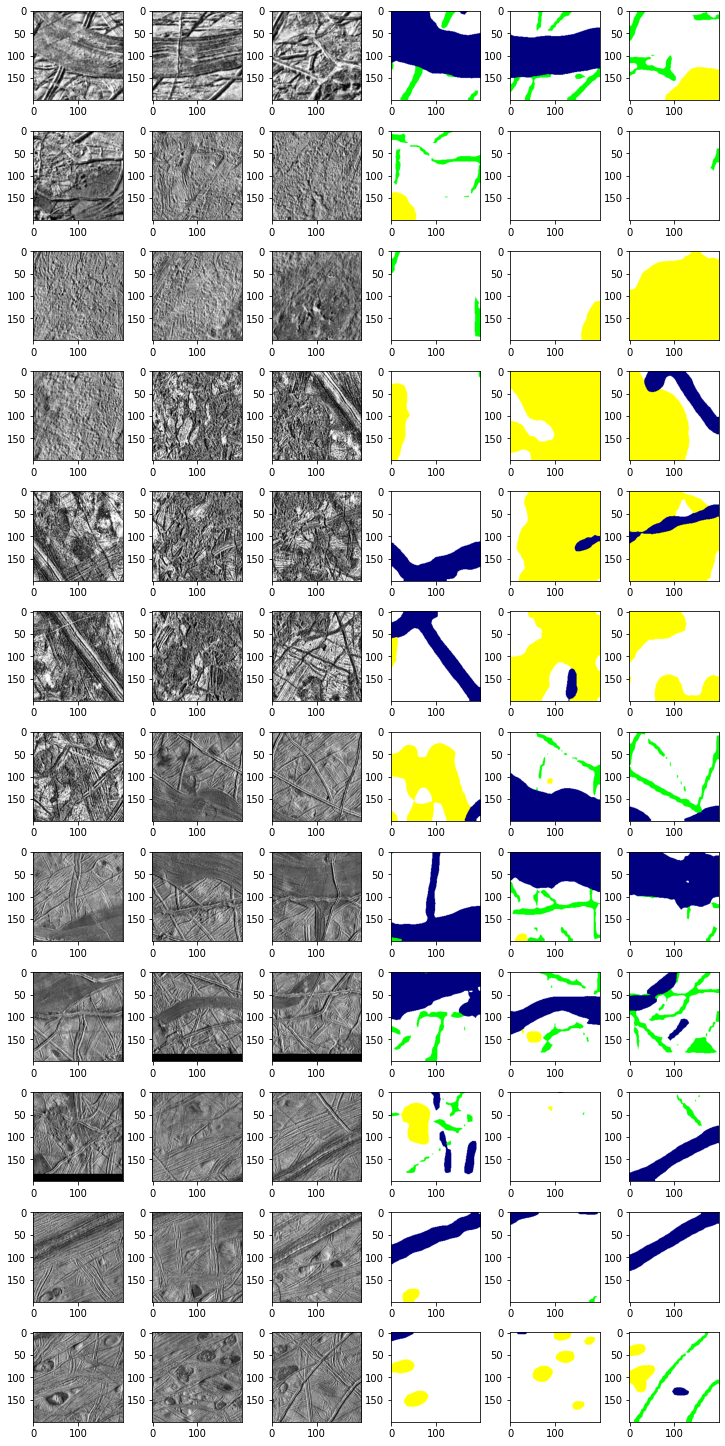

In [ ]:
# subplots those images with masks

nb_rows = 12 # number of rows in subplots
nb_cols = 6 # number of columns in subplots


fig, axarr = plt.subplots(nb_rows,nb_cols,figsize=(10,20))

for idx in range(nb_rows):
    for idy in range(nb_cols):
        if idy<nb_cols/2:       
            index_img = idx*(int(nb_cols/2))+idy
            axarr[idx][idy].imshow(all_images_after_crop[index_img],cmap='gray')  # show original images in first 5 columns
        else:
            index_img = idx*int(nb_cols/2)+idy-int(nb_cols/2)
            axarr[idx][idy].imshow(create_mask_image(y_preds_full[index_img]))  # show the corresponding edges in the last 5 columns

plt.show()

# Visualization of validation loader

In [ ]:
y_preds_validation = predict(model_deeplabv3_prediction,criterion,validation_loader) # get the predictions of test set

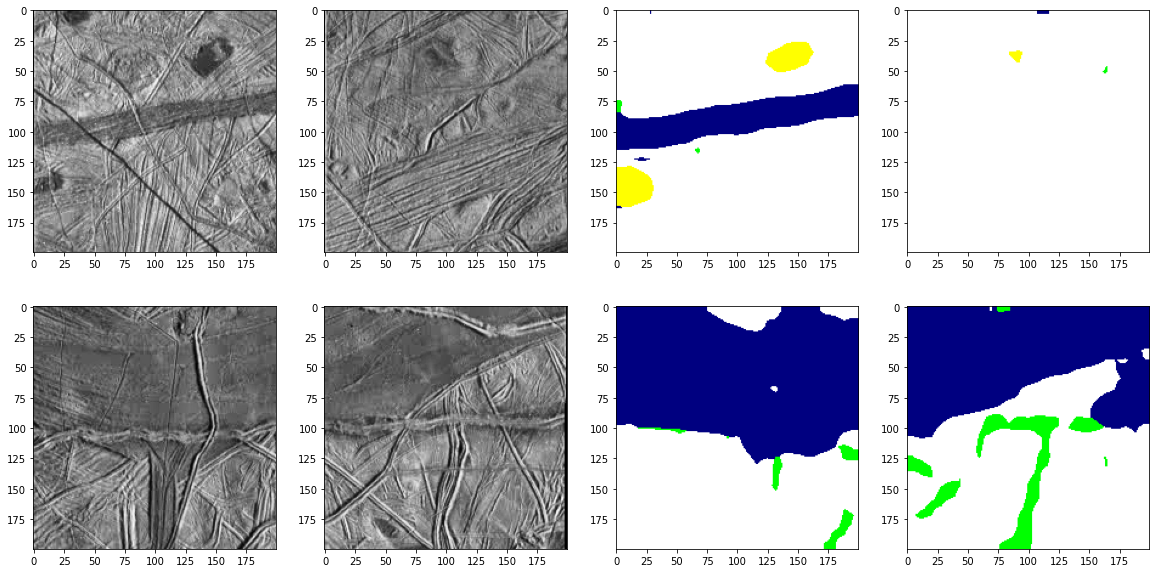

In [ ]:
# subplots those images with masks

nb_rows = 2 # number of rows in subplots
nb_cols = 4 # number of columns in subplots


fig, axarr = plt.subplots(nb_rows,nb_cols,figsize=(20,10))

for idx in range(nb_rows):
    for idy in range(nb_cols):
        if idy<2:       
            index_img = idx*(int(nb_cols/2))+idy
            #print(index_img)
            axarr[idx][idy].imshow(validation_images[index_img],cmap='gray')  # show original images in first 5 columns
        else:
            index_img = idx*int(nb_cols/2)+idy-int(nb_cols/2)
            #print(index_img)
            axarr[idx][idy].imshow(create_mask_image(y_preds_validation[index_img]))  # show the corresponding edges in the last 5 columns